In [16]:
## IMPORTS

import os
import torch
import numpy as np
import nibabel as nib
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score



import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import os


import umap


from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, label_binarize
from xgboost import XGBClassifier, XGBRegressor
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from lifelines import CoxPHFitter


In [17]:

# --- Paths and Model ---
DINO_MODEL_NAME = "facebook/dinov2-base"
CHECKPOINT_PATH = "/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/runs/dino_full_public/checkpoints/checkpoint_step180000_epoch10.pt"
PDGM_DIR = "/oak/stanford/groups/ogevaert/data/brain_mri_tumor_project/UCSF-PDGM-v3"
SAVE_PATH = "/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/dino_pdgm_features_180000.npz"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# --- Projection Head definition ---
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim=256):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Linear(out_dim, out_dim)
        )
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.proj(x)


# --- Load DINO backbone and projection head ---
processor = AutoImageProcessor.from_pretrained(DINO_MODEL_NAME)
vit = AutoModel.from_pretrained(DINO_MODEL_NAME).to(DEVICE)
proj_head = ProjectionHead(vit.config.hidden_size).to(DEVICE)

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
vit.load_state_dict(ckpt["backbone"])
proj_head.load_state_dict(ckpt["head"])
vit.eval()
proj_head.eval()

# --- Preprocessing helper ---
def preprocess_slice(slice_2d):
    # Normalize and convert to uint8
    slice_2d = np.uint8(255 * np.clip(slice_2d, 0, 1))
    # DINO expects 3 channels; stack if needed
    if slice_2d.ndim == 2:
        slice_2d = np.stack([slice_2d]*3, axis=-1)
    return processor(images=slice_2d, return_tensors="pt")["pixel_values"].squeeze(0)

# --- Feature extraction ---
features, case_ids = [], []
case_dirs = sorted([d for d in os.listdir(PDGM_DIR) if d.startswith("UCSF-PDGM-")])

for case_folder in tqdm(case_dirs):
    case_path = os.path.join(PDGM_DIR, case_folder)
    num4 = case_folder.split("-")[-1].split("_")[0]
    file_case_id = f"UCSF-PDGM-{num4}"
    t1c_path = os.path.join(case_path, f"{file_case_id}_T1c_bias.nii.gz")
    if not os.path.exists(t1c_path):
        continue

    img = nib.load(t1c_path).get_fdata().astype(np.float32)
    img = img / (np.max(img) + 1e-8)
    slice_embeds = []
    for i in range(img.shape[2]):
        slice_2d = img[:, :, i]
        if np.std(slice_2d) < 1e-5:
            continue
        input_tensor = preprocess_slice(slice_2d).to(DEVICE)
        with torch.no_grad():
            embed = vit(input_tensor.unsqueeze(0)).last_hidden_state[:, 0, :]
            proj = proj_head(embed)
            slice_embeds.append(proj.cpu().numpy().squeeze())
    if len(slice_embeds) == 0:
        continue
    case_embed = np.mean(np.stack(slice_embeds), axis=0)
    features.append(case_embed)
    case_ids.append(file_case_id)

features = np.stack(features)
np.savez(SAVE_PATH, features=features, case_ids=np.array(case_ids))
print(f"Saved DINO features to {SAVE_PATH}")

100%|██████████| 501/501 [15:20<00:00,  1.84s/it]

Saved DINO features to /oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/dino_pdgm_features_180000.npz


In [19]:
# --- Load features and metadata ---
METADATA_CSV="/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/metadata/PGDM/UCSF-PDGM-metadata_v2.csv"
data = np.load("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/dino_pdgm_features_180000.npz", allow_pickle=True)
X = data["features"]
case_ids = data["case_ids"]
meta = pd.read_csv(METADATA_CSV).set_index("ID")


In [21]:
# --- Fix case_ids to match metadata index ---
case_ids = np.array([f"UCSF-PDGM-{int(cid.split('-')[-1]):03d}" for cid in case_ids])
valid_mask = np.isin(case_ids, meta.index)
X = X[valid_mask]
case_ids = case_ids[valid_mask]

/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== Sex | Random Forest ===


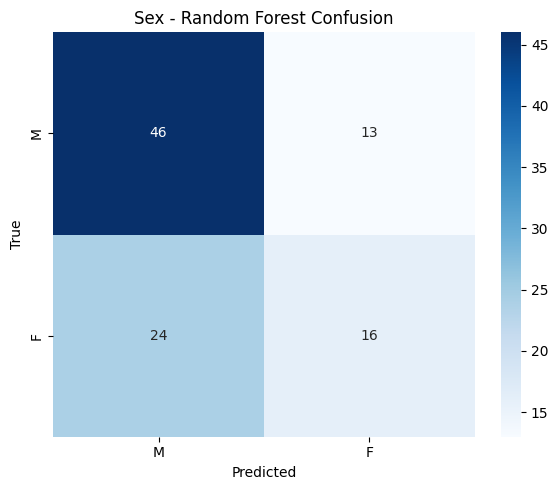

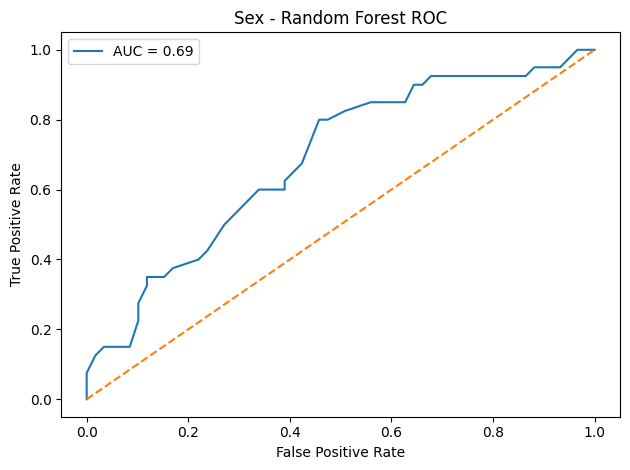

              precision    recall  f1-score   support

           M       0.66      0.78      0.71        59
           F       0.55      0.40      0.46        40

    accuracy                           0.63        99
   macro avg       0.60      0.59      0.59        99
weighted avg       0.61      0.63      0.61        99

AUC: 0.69

=== Sex | Logistic Regression ===


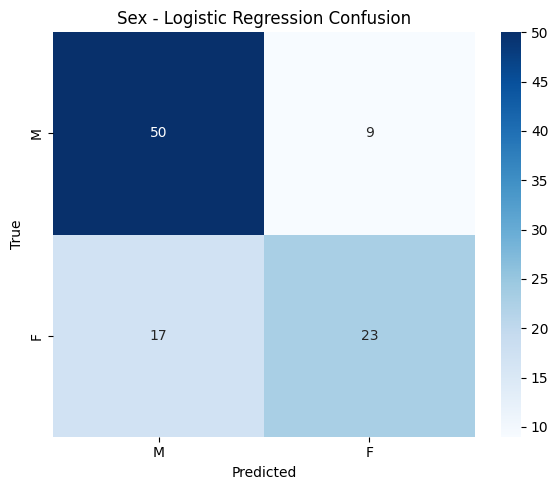

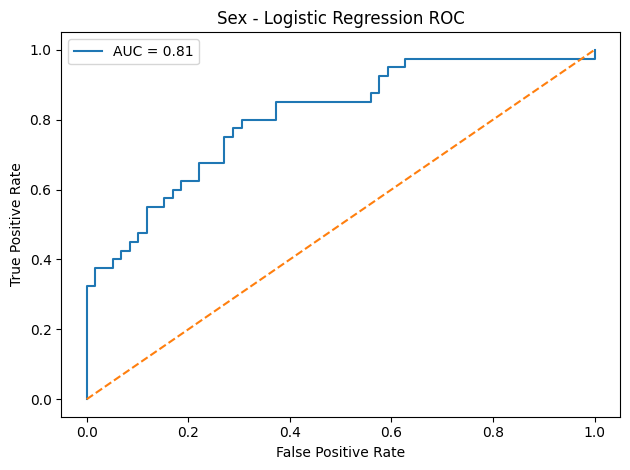

              precision    recall  f1-score   support

           M       0.75      0.85      0.79        59
           F       0.72      0.57      0.64        40

    accuracy                           0.74        99
   macro avg       0.73      0.71      0.72        99
weighted avg       0.74      0.74      0.73        99

AUC: 0.81

=== Sex | XGBoost ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


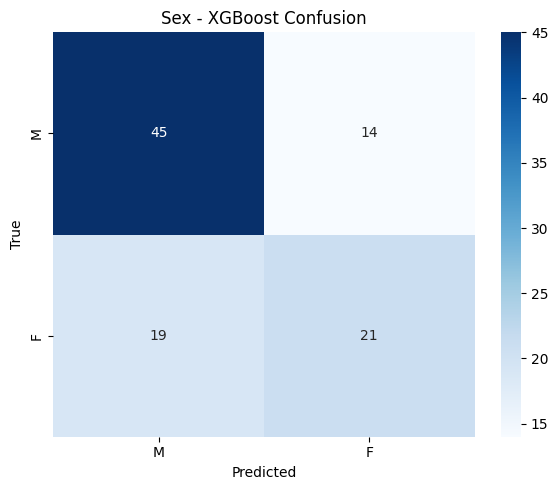

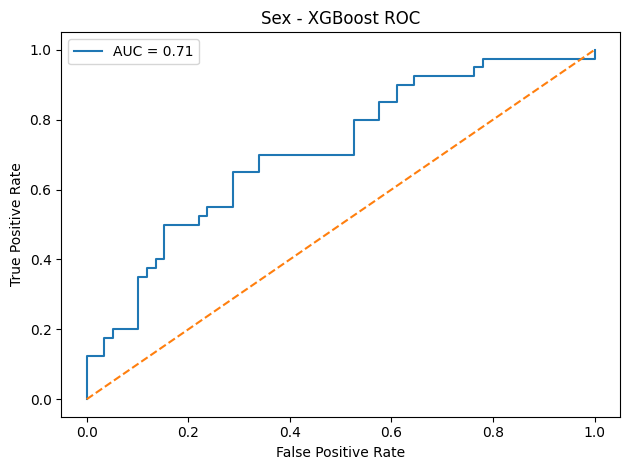

              precision    recall  f1-score   support

           M       0.70      0.76      0.73        59
           F       0.60      0.53      0.56        40

    accuracy                           0.67        99
   macro avg       0.65      0.64      0.65        99
weighted avg       0.66      0.67      0.66        99

AUC: 0.71


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



=== MGMT status | Random Forest ===


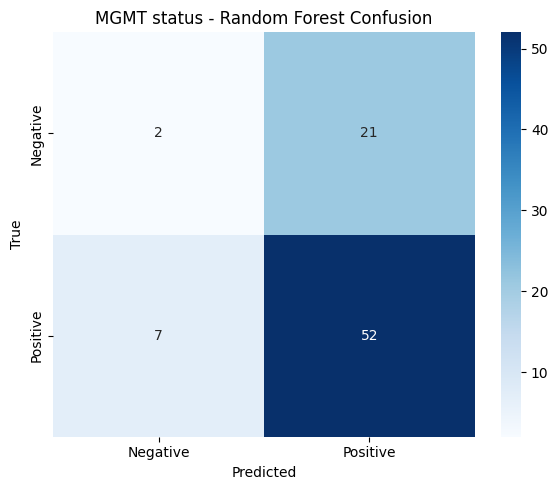

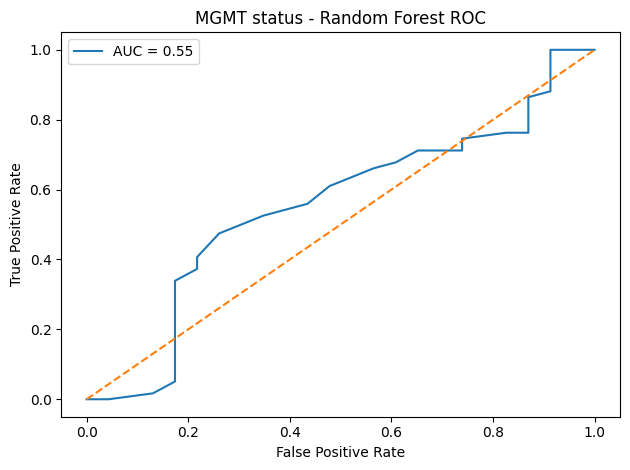

              precision    recall  f1-score   support

    Negative       0.22      0.09      0.12        23
    Positive       0.71      0.88      0.79        59

    accuracy                           0.66        82
   macro avg       0.47      0.48      0.46        82
weighted avg       0.57      0.66      0.60        82

AUC: 0.55

=== MGMT status | Logistic Regression ===


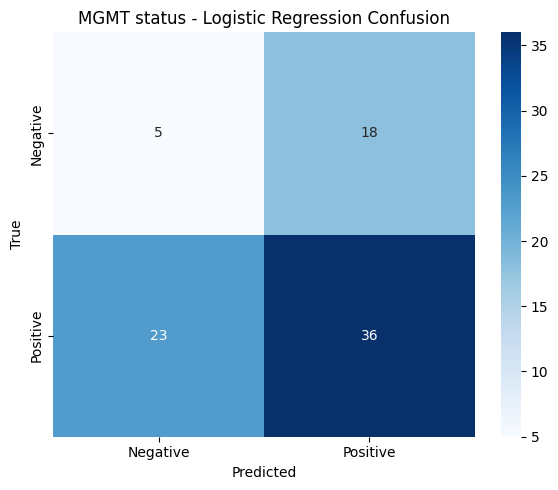

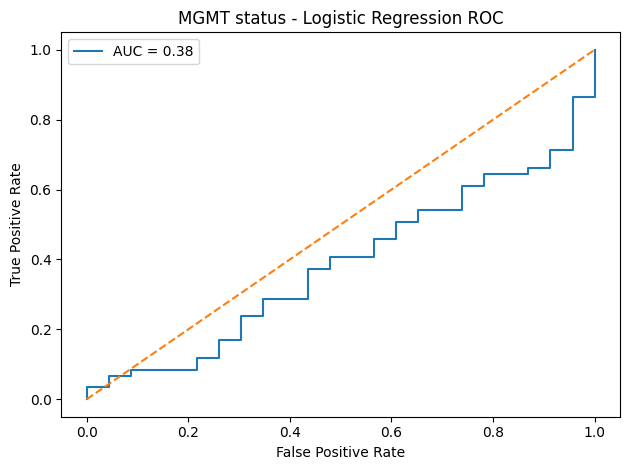

              precision    recall  f1-score   support

    Negative       0.18      0.22      0.20        23
    Positive       0.67      0.61      0.64        59

    accuracy                           0.50        82
   macro avg       0.42      0.41      0.42        82
weighted avg       0.53      0.50      0.51        82

AUC: 0.38

=== MGMT status | XGBoost ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


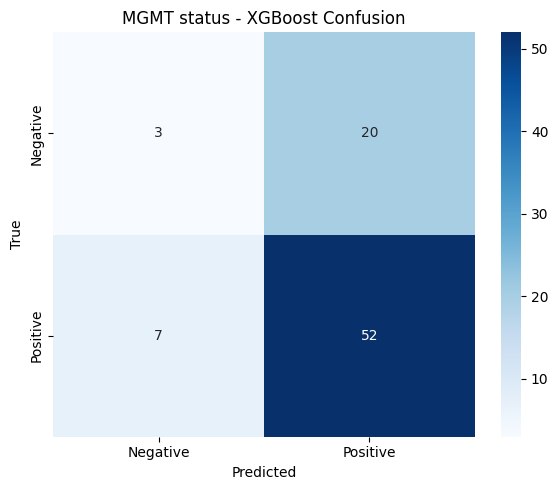

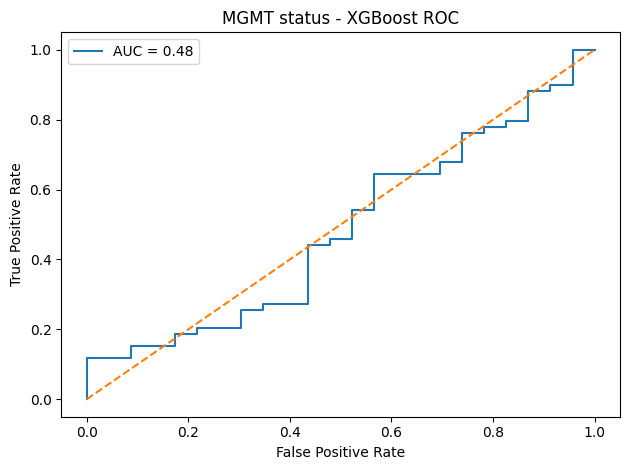

              precision    recall  f1-score   support

    Negative       0.30      0.13      0.18        23
    Positive       0.72      0.88      0.79        59

    accuracy                           0.67        82
   macro avg       0.51      0.51      0.49        82
weighted avg       0.60      0.67      0.62        82

AUC: 0.48

=== IDH mutation status | Random Forest ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


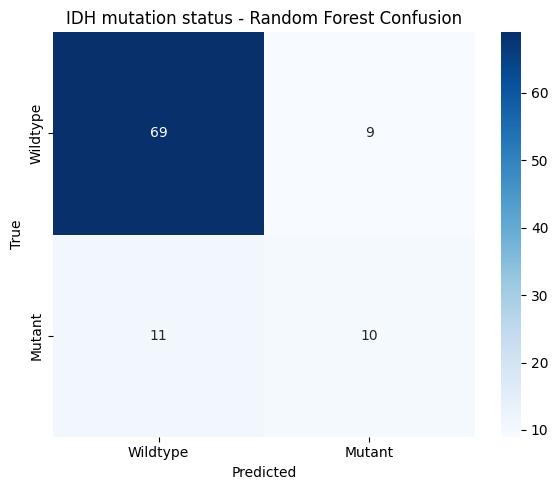

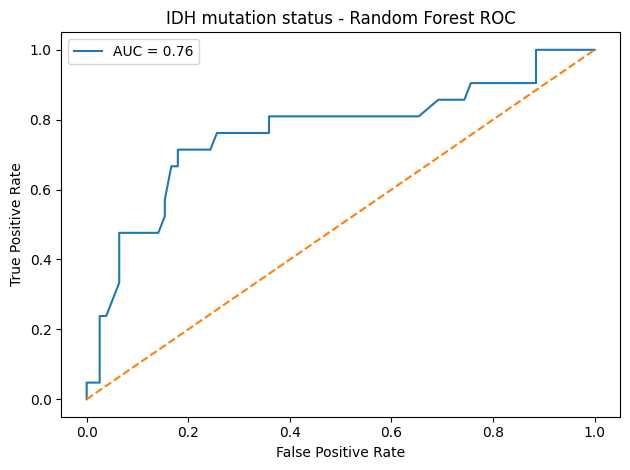

              precision    recall  f1-score   support

    Wildtype       0.86      0.88      0.87        78
      Mutant       0.53      0.48      0.50        21

    accuracy                           0.80        99
   macro avg       0.69      0.68      0.69        99
weighted avg       0.79      0.80      0.79        99

AUC: 0.76

=== IDH mutation status | Logistic Regression ===


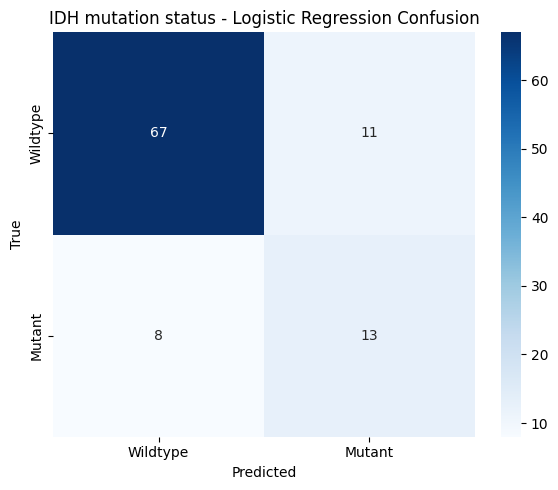

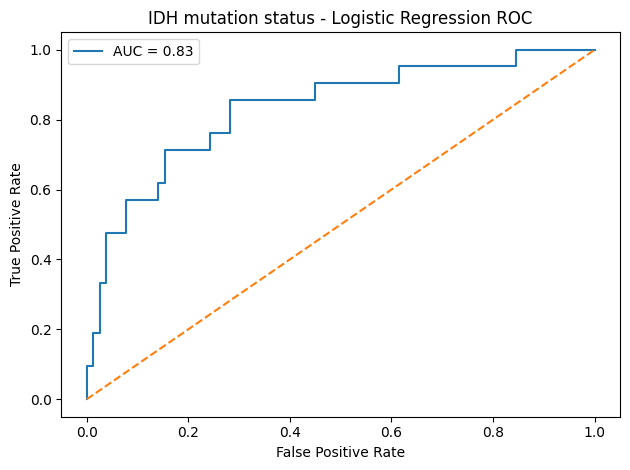

              precision    recall  f1-score   support

    Wildtype       0.89      0.86      0.88        78
      Mutant       0.54      0.62      0.58        21

    accuracy                           0.81        99
   macro avg       0.72      0.74      0.73        99
weighted avg       0.82      0.81      0.81        99

AUC: 0.83

=== IDH mutation status | XGBoost ===


/oak/stanford/groups/ogevaert/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:42:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


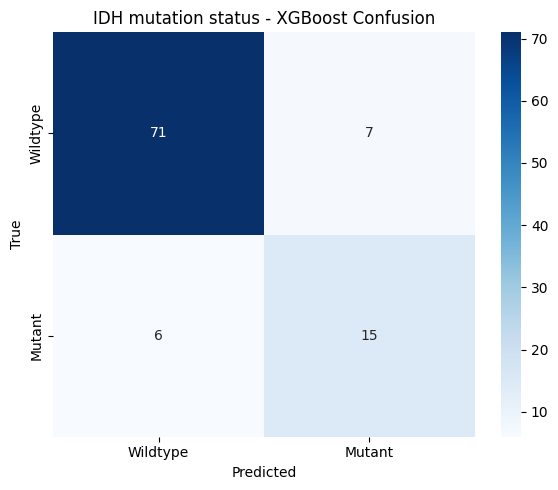

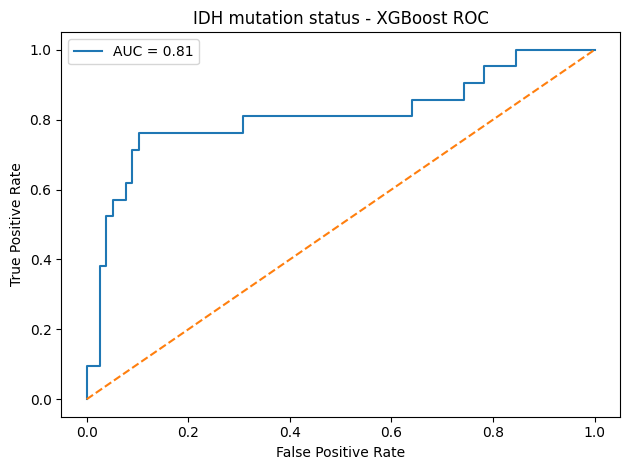

              precision    recall  f1-score   support

    Wildtype       0.92      0.91      0.92        78
      Mutant       0.68      0.71      0.70        21

    accuracy                           0.87        99
   macro avg       0.80      0.81      0.81        99
weighted avg       0.87      0.87      0.87        99

AUC: 0.81

--- Age Regression | Ridge ---
MAE: 9.11
MSE: 127.77
R^2: 0.50


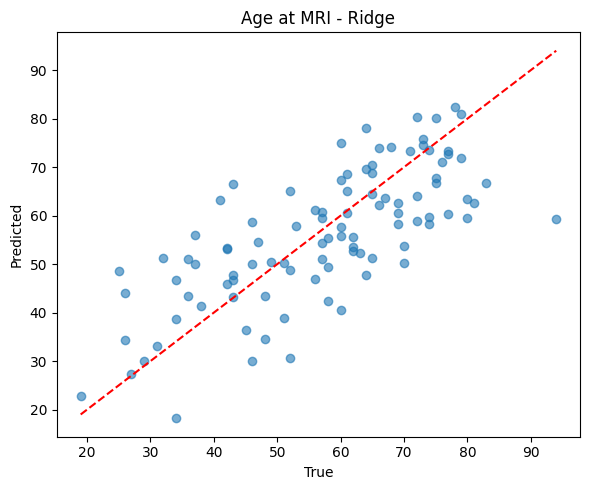


--- Age Regression | Random Forest ---
MAE: 9.80
MSE: 151.18
R^2: 0.41


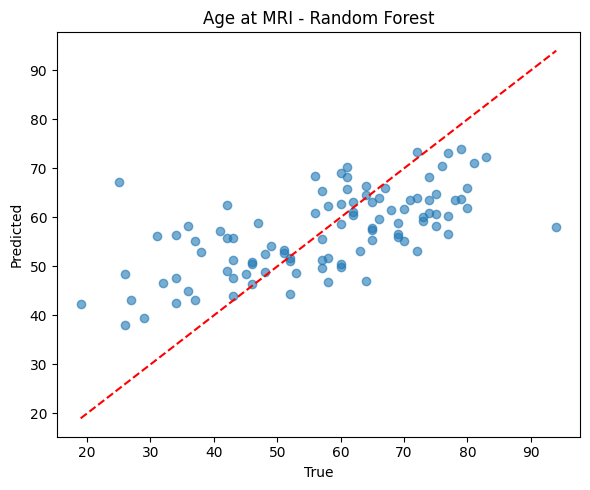


--- Age Regression | XGBoost ---
MAE: 9.55
MSE: 144.06
R^2: 0.44


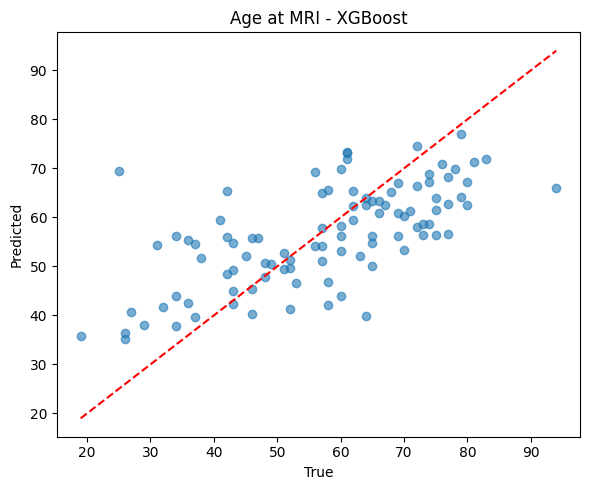


=== OS Cox Regression ===
C-index: 0.650


In [22]:

# --- Plotting Utilities ---
def plot_confusion(cm, class_names, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_score, n_classes=2, title="ROC Curve"):
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {auc_val:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return auc_val
    else:
        y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
        fpr, tpr, roc_auc = {}, {}, {}
        plt.figure()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f"Class {i} AUC = {roc_auc[i]:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return roc_auc

# --- Classification Tasks ---
tasks = {
    "Sex": {
        "labels": meta.loc[case_ids, "Sex"].map({"M": 0, "F": 1}).values,
        "class_names": ["M", "F"]
    },
    "MGMT status": {
        "labels": meta.loc[case_ids, "MGMT status"].replace("indeterminate", np.nan).map({"negative": 0, "positive": 1}).values,
        "class_names": ["Negative", "Positive"]
    },
    "IDH mutation status": {
        "labels": np.array([0 if str(v).strip().lower() == "wildtype" else 1 for v in meta.loc[case_ids, "IDH"]]),
        "class_names": ["Wildtype", "Mutant"]
    }
}

for name, info in tasks.items():
    y = info["labels"]
    classes = info["class_names"]
    n_classes = len(set(classes))
    valid_mask = ~pd.isnull(y)
    X_valid, y_valid = X[valid_mask], y[valid_mask]

    X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, stratify=y_valid, test_size=0.2, random_state=42)

    # SMOTE
    class_counts = Counter(y_train)
    min_class_count = min(class_counts.values())
    if len(class_counts) > 1 and min_class_count > 1:
        k_neighbors = min(5, min_class_count - 1)
        sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    else:
        print(f"⚠️ Skipping SMOTE for {name}")
        X_train_res, y_train_res = X_train, y_train

    classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train_res == 0).sum() / (y_train_res == 1).sum())
    }

    for clf_name, clf in classifiers.items():
        print(f"\n=== {name} | {clf_name} ===")
        if clf_name == "Logistic Regression":
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_res)
            X_test_scaled = scaler.transform(X_test)
            clf.fit(X_train_scaled, y_train_res)
            y_pred = clf.predict(X_test_scaled)
            y_score = clf.predict_proba(X_test_scaled)[:, 1] if n_classes == 2 else clf.predict_proba(X_test_scaled)
        else:
            clf.fit(X_train_res, y_train_res)
            y_pred = clf.predict(X_test)
            y_score = clf.predict_proba(X_test)[:, 1] if n_classes == 2 else clf.predict_proba(X_test)

        cm = confusion_matrix(y_test, y_pred)
        plot_confusion(cm, classes, f"{name} - {clf_name} Confusion")
        auc_val = plot_roc(y_test, y_score, n_classes=n_classes, title=f"{name} - {clf_name} ROC")
        print(classification_report(y_test, y_pred, target_names=[str(c) for c in classes]))
        if isinstance(auc_val, dict):
            for cls_idx, val in auc_val.items():
                print(f"AUC (Class {cls_idx}): {val:.2f}")
        else:
            print(f"AUC: {auc_val:.2f}")

# --- Age Regression ---
age = meta.loc[case_ids, "Age at MRI"].astype(float).values
valid_mask = ~pd.isnull(age)
X_age, y_age = X[valid_mask], age[valid_mask]
X_train, X_test, y_train, y_test = train_test_split(X_age, y_age, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

regressors = {
    "Ridge": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
}

for name, model in regressors.items():
    print(f"\n--- Age Regression | {name} ---")
    if name == "Ridge":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
    print(f"R^2: {r2_score(y_test, y_pred):.2f}")
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"Age at MRI - {name}")
    plt.tight_layout()
    plt.show()

# --- OS Survival Analysis with PCA-reduced Cox ---
os_time = meta.loc[case_ids, "OS"]
os_event = np.ones_like(os_time)  # placeholder: all uncensored
valid_mask = ~pd.isnull(os_time)
X_os = X[valid_mask]
y_os_time = os_time[valid_mask]
y_os_event = os_event[valid_mask]

scaler = StandardScaler()
X_os_scaled = scaler.fit_transform(X_os)
pca = PCA(n_components=20)
X_os_reduced = pca.fit_transform(X_os_scaled)

cox_df = pd.DataFrame(X_os_reduced, columns=[f"PC{i+1}" for i in range(X_os_reduced.shape[1])])
cox_df["duration"] = y_os_time.values
cox_df["event"] = y_os_event

cph = CoxPHFitter()
cph.fit(cox_df, duration_col="duration", event_col="event")
c_index = cph.concordance_index_
print(f"\n=== OS Cox Regression ===\nC-index: {c_index:.3f}")


In [9]:
data = np.load("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/dino_pdgm_features_1e4lr160000.npz", allow_pickle=True)
X = data["features"]
case_ids = data["case_ids"]
meta = pd.read_csv("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/metadata/PGDM/UCSF-PDGM-metadata_v2.csv").set_index("ID")

# --- Standardize case_ids to three digits and filter ---
case_ids_fixed = np.array([f"UCSF-PDGM-{int(cid.split('-')[-1]):03d}" for cid in case_ids])
valid_mask = np.isin(case_ids_fixed, meta.index)
X = X[valid_mask]
case_ids_fixed = case_ids_fixed[valid_mask]

# --- Standardize features and run t-SNE ---
X_scaled = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# --- Metadata columns to visualize ---
columns = [
    "ID", "Sex", "Age at MRI", "WHO CNS Grade", "Final pathologic diagnosis (WHO 2021)",
    "MGMT status", "MGMT index", "1p/19q", "IDH", "1-dead 0-alive", "OS", "EOR",
    "Biopsy prior to imaging", "BraTS21 ID", "BraTS21 Segmentation Cohort", "BraTS21 MGMT Cohort"
]

outdir = "/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/tsne_plots/PDGM_dino"
os.makedirs(outdir, exist_ok=True)

for column in columns:
    try:
        values = meta.loc[case_ids_fixed, column].values
    except KeyError:
        print(f"Column {column} not found in metadata.")
        continue

    # Convert all values to string, replace nan with "NA"
    values_str = np.array([str(v) if pd.notna(v) else "NA" for v in values])

    plt.figure(figsize=(7, 6))
    for val in np.unique(values_str):
        idx = values_str == val
        plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=str(val), alpha=0.7, s=20)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"t-SNE colored by {column}")
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    plt.tight_layout()
    fname = f"tsne_{column.replace(' ', '_').replace('/', '_')}.png"
    plt.savefig(os.path.join(outdir, fname))
    plt.close()
    print(f"Saved t-SNE for {column}")

print("All t-SNE plots saved")

Column ID not found in metadata.
Saved t-SNE for Sex


/tmp/ipykernel_9975/1227058388.py:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved t-SNE for Age at MRI
Saved t-SNE for WHO CNS Grade
Saved t-SNE for Final pathologic diagnosis (WHO 2021)
Saved t-SNE for MGMT status
Saved t-SNE for MGMT index
Saved t-SNE for 1p/19q
Saved t-SNE for IDH
Saved t-SNE for 1-dead 0-alive


/tmp/ipykernel_9975/1227058388.py:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved t-SNE for OS
Saved t-SNE for EOR
Saved t-SNE for Biopsy prior to imaging


/tmp/ipykernel_9975/1227058388.py:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved t-SNE for BraTS21 ID
Saved t-SNE for BraTS21 Segmentation Cohort
Saved t-SNE for BraTS21 MGMT Cohort
All t-SNE plots saved


In [11]:


data = np.load("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/features/dino_pdgm_features_1e4lr160000.npz", allow_pickle=True)
X = data["features"]
case_ids = data["case_ids"]
meta = pd.read_csv("/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/metadata/PGDM/UCSF-PDGM-metadata_v2.csv").set_index("ID")

# --- Standardize case_ids to three digits and filter ---
case_ids_fixed = np.array([f"UCSF-PDGM-{int(cid.split('-')[-1]):03d}" for cid in case_ids])
valid_mask = np.isin(case_ids_fixed, meta.index)
X = X[valid_mask]
case_ids_fixed = case_ids_fixed[valid_mask]

# --- Standardize features and run UMAP ---
X_scaled = StandardScaler().fit_transform(X)
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# --- Metadata columns to visualize ---
columns = [
    "ID", "Sex", "Age at MRI", "WHO CNS Grade", "Final pathologic diagnosis (WHO 2021)",
    "MGMT status", "MGMT index", "1p/19q", "IDH", "1-dead 0-alive", "OS", "EOR",
    "Biopsy prior to imaging", "BraTS21 ID", "BraTS21 Segmentation Cohort", "BraTS21 MGMT Cohort"
]

outdir = "/oak/stanford/groups/ogevaert/maxvpuyv/projects/brain/data/umap_plots/PDGM_dino"
os.makedirs(outdir, exist_ok=True)

for column in columns:
    try:
        values = meta.loc[case_ids_fixed, column].values
    except KeyError:
        print(f"Column {column} not found in metadata.")
        continue

    # Convert all values to string, replace nan with "NA"
    values_str = np.array([str(v) if pd.notna(v) else "NA" for v in values])

    plt.figure(figsize=(7, 6))
    for val in np.unique(values_str):
        idx = values_str == val
        plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=str(val), alpha=0.7, s=20)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"UMAP colored by {column}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    fname = f"umap_{column.replace(' ', '_').replace('/', '_')}.png"
    plt.savefig(os.path.join(outdir, fname))
    plt.close()
    print(f"Saved UMAP for {column}")

print("All UMAP plots saved")

/scratch/users/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/scratch/users/maxvpuyv/anaconda3/envs/brain/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Column ID not found in metadata.
Saved UMAP for Sex


/tmp/ipykernel_9975/4011970878.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved UMAP for Age at MRI
Saved UMAP for WHO CNS Grade
Saved UMAP for Final pathologic diagnosis (WHO 2021)
Saved UMAP for MGMT status
Saved UMAP for MGMT index
Saved UMAP for 1p/19q
Saved UMAP for IDH
Saved UMAP for 1-dead 0-alive


/tmp/ipykernel_9975/4011970878.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved UMAP for OS
Saved UMAP for EOR
Saved UMAP for Biopsy prior to imaging


/tmp/ipykernel_9975/4011970878.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved UMAP for BraTS21 ID
Saved UMAP for BraTS21 Segmentation Cohort
Saved UMAP for BraTS21 MGMT Cohort
All UMAP plots saved
